In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import glob
import os
from random import randint

In [2]:
protoFile = "pose/coco/pose_deploy_linevec.prototxt"
weightsFile = "pose/coco/pose_iter_440000.caffemodel"
nPoints = 18

keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs correspoding to the POSE_PAIRS
# e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], 
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30], 
          [47,48], [49,50], [53,54], [51,52], [55,56], 
          [37,38], [45,46]]

colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]

# Define the path to the .mdb dataset directory
data_dir_images = "dataset/multi_person/coco_dataset"
data_dir_videos = "dataset/multi_person/videos"
#data_dir_images = "dataset/testd"
#data_dir_videos = "dataset/testd"

# Define the path to the output directory for the processed images
output_dir_images = "results/multi_person/images"
output_dir_videos = "results/multi_person/videos"
#output_dir_images = "results/testr"
#output_dir_videos = "results/testr"

if not os.path.exists(output_dir_images):
    os.makedirs(output_dir_images)
    
if not os.path.exists(output_dir_videos):
    os.makedirs(output_dir_videos)
    
file = "predicted_keypoints/multipredictions.txt"


In [3]:
# Find the Keypoints using Non Maximum Suppression on the Confidence Map
def getKeypoints(probMap, threshold=0.1):
    
    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []
    
    #find the blobs
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints


## Use the following equation for finding valid joint-pairs

![](./pose-estimation-paf-equation.png)

In the above equation:

L is the PAF;

d is the vector joining two joints;

p is the interpolated point between two joints;

It is implemented using the dot product between the PAF and the vector $d_{ij}$

In [4]:
# Find valid connections between the different joints of a all persons present
def getValidPairs(output):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1
    conf_th = 0.7
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB 
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid
        
        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ]) 
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)
                    
                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair  
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:            
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            #print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    #print(valid_pairs)
    return valid_pairs, invalid_pairs


In [5]:
# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint
def getPersonwiseKeypoints(valid_pairs, invalid_pairs):
    # the last number in each row is the overall score 
    personwiseKeypoints = -1 * np.ones((0, 19))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])): 
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score 
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints

In [6]:
frame = cv2.imread("group.jpg")
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]

### Load the network and pass the image through the network

In [7]:
t = time.time()
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)


net.setPreferableBackend(cv2.dnn.DNN_TARGET_CPU)


# Fix the input Height and get the width according to the Aspect Ratio
inHeight = 368
inWidth = int((inHeight/frameHeight)*frameWidth)

inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)
output = net.forward()
print("Time Taken = {}".format(time.time() - t))

Time Taken = 1.4062280654907227


### Slice a probability map ( for e.g Nose ) from the output for a specific keypoint and plot the heatmap ( after resizing ) on the image itself

(-0.5, 639.5, 414.5, -0.5)

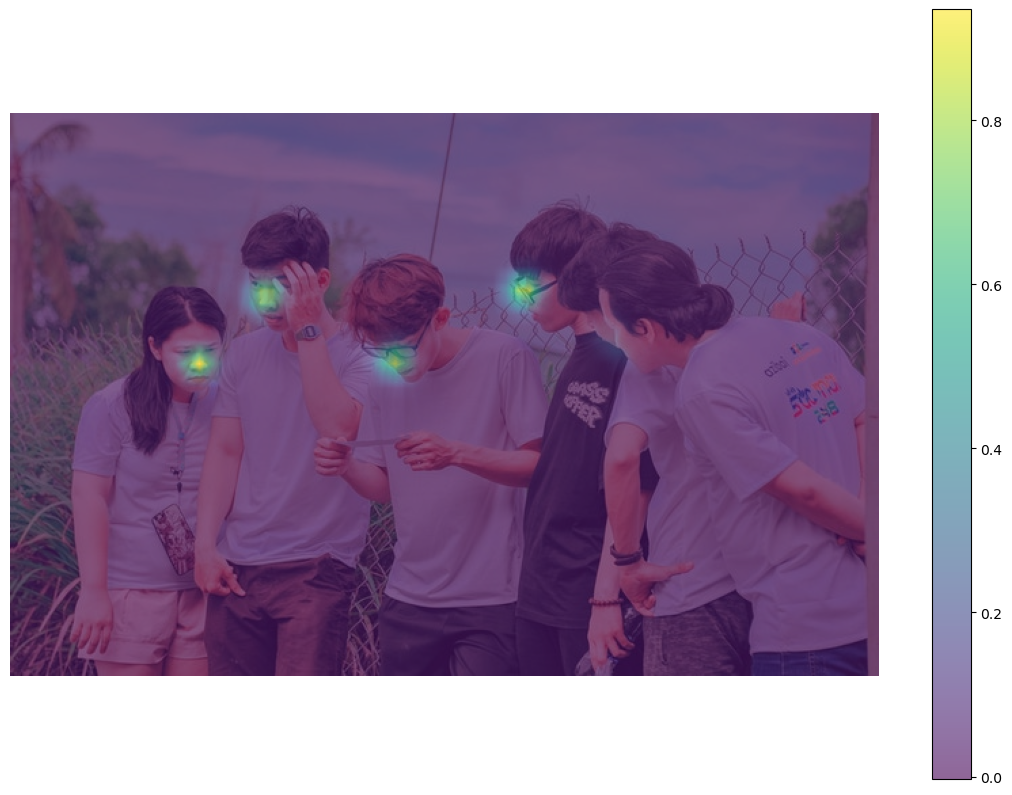

In [8]:
i = 0
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (frameWidth, frameHeight))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

In [9]:
detected_keypoints = []
keypoints_list = np.zeros((0,3))
keypoint_id = 0
threshold = 0.1

for part in range(nPoints):
    probMap = output[0,part,:,:]
    probMap = cv2.resize(probMap, (frame.shape[1], frame.shape[0]))
    keypoints = getKeypoints(probMap, threshold)
    print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
    keypoints_with_id = []
    for i in range(len(keypoints)):
        keypoints_with_id.append(keypoints[i] + (keypoint_id,))
        keypoints_list = np.vstack([keypoints_list, keypoints[i]])
        keypoint_id += 1

    detected_keypoints.append(keypoints_with_id)
    
frameClone = frame.copy()
valid_pairs, invalid_pairs = getValidPairs(output)
personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)

Keypoints - Nose : [(139, 184, 0.93562615), (283, 184, 0.7527163), (445, 167, 0.1642556), (185, 132, 0.70591664), (375, 130, 0.7945155)]
Keypoints - Neck : [(120, 212, 0.70358175), (319, 185, 0.73628783), (544, 184, 0.51472574), (429, 176, 0.53250325), (212, 176, 0.77075535)]
Keypoints - R-Sho : [(76, 213, 0.62042767), (274, 193, 0.6070034), (410, 176, 0.5143723), (175, 175, 0.72982275), (589, 166, 0.48056006)]
Keypoints - R-Elb : [(58, 284, 0.7548365), (275, 274, 0.7440606), (157, 247, 0.6935944), (626, 229, 0.34438294)]
Keypoints - R-Wr : [(59, 348, 0.71521765), (140, 319, 0.6388691), (247, 257, 0.7846046)]
Keypoints - L-Sho : [(158, 212, 0.50267404), (509, 203, 0.6435662), (364, 176, 0.6395583), (256, 176, 0.6045459), (455, 176, 0.49591684)]
Keypoints - L-Elb : [(582, 275, 0.56628466), (391, 256, 0.6751583), (454, 248, 0.6378699), (246, 230, 0.3962223)]
Keypoints - L-Wr : [(454, 329, 0.4407238), (636, 301, 0.22945799), (328, 248, 0.7759248), (220, 157, 0.57482934)]
Keypoints - R-Hip

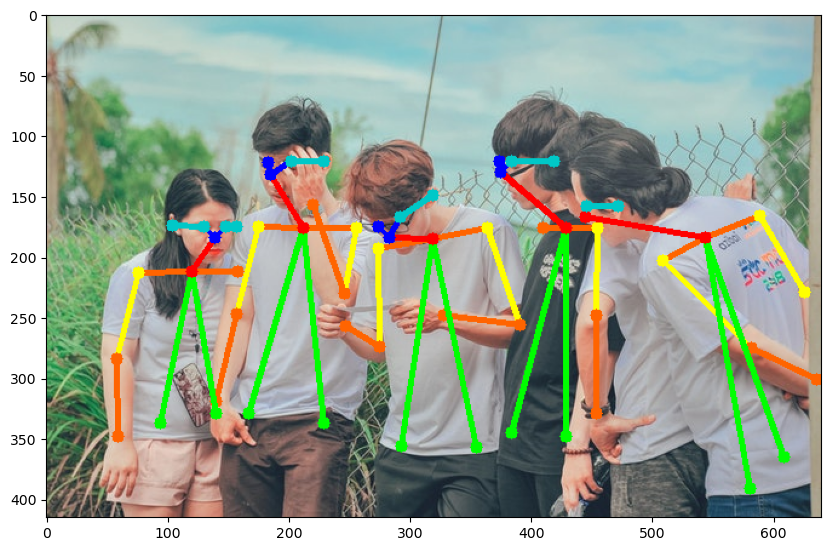

In [10]:
for i in range(17):
    for n in range(len(personwiseKeypoints)):
        index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
        if -1 in index:
            continue
        B = np.int32(keypoints_list[index.astype(int), 0])
        A = np.int32(keypoints_list[index.astype(int), 1])
        cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3)
        cv2.circle(frameClone, (B[0], A[0]), 5, colors[i], -1)
        cv2.circle(frameClone, (B[1], A[1]), 5, colors[i], -1)
        
plt.figure(figsize=[10,10])
plt.imshow(frameClone[:,:,[2,1,0]])

### img

In [11]:
### LOOP STARTS HERE
t = time.time()


for img_file in os.listdir(data_dir_images):
    if img_file.endswith(".jpg"):
        img_path = os.path.join(data_dir_images, img_file)
        frame = cv2.imread(img_path)
        frameCopy = np.copy(frame)
        frameWidth = frame.shape[1]
        frameHeight = frame.shape[0]


        net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

        net.setPreferableBackend(cv2.dnn.DNN_TARGET_CPU)

        # Fix the input Height and get the width according to the Aspect Ratio
        inHeight = 368
        inWidth = int((inHeight/frameHeight)*frameWidth)

        inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                                  (0, 0, 0), swapRB=False, crop=False)

        net.setInput(inpBlob)
        output = net.forward()

        i = 0
        probMap = output[0, i, :, :]
        probMap = cv2.resize(probMap, (frameWidth, frameHeight))

        detected_keypoints = []
        keypoints_list = np.zeros((0,3))
        keypoint_id = 0
        threshold = 0.1

        for part in range(nPoints):
            probMap = output[0,part,:,:]
            probMap = cv2.resize(probMap, (frame.shape[1], frame.shape[0]))
            keypoints = getKeypoints(probMap, threshold)
            #print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
            keypoints_with_id = []
            for i in range(len(keypoints)):
                keypoints_with_id.append(keypoints[i] + (keypoint_id,))
                keypoints_list = np.vstack([keypoints_list, keypoints[i]])
                keypoint_id += 1

            detected_keypoints.append(keypoints_with_id)

        frameClone = frame.copy()
        valid_pairs, invalid_pairs = getValidPairs(output)
        personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)

        for i in range(17):
            for n in range(len(personwiseKeypoints)):
                index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
                if -1 in index:
                    continue
                B = np.int32(keypoints_list[index.astype(int), 0])
                A = np.int32(keypoints_list[index.astype(int), 1])
                cv2.line(frame, (B[0], A[0]), (B[1], A[1]), colors[i], 3)
                cv2.circle(frame, (B[0], A[0]), 5, colors[i], -1)
                cv2.circle(frame, (B[1], A[1]), 5, colors[i], -1)
        #plt.figure(figsize=[15,15])
        #plt.imshow(frame[:,:,[2,1,0]])        
        # Save the processed image to the output directory
        file_name = os.path.basename(img_path)
        output_path = os.path.join(output_dir_images, file_name)
        cv2.imwrite(output_path, frame)
        with open(file, 'a') as f:
            min_detected = min(len(detected_keypoints[joint]) for joint in range(nPoints))  # find the minimum number of persons detected across all joint types
            for person in range(min_detected):  # only iterate over indices that exist for all joint types
                person_keypoints = [detected_keypoints[joint][person][:2] for joint in range(nPoints)]
                f.write(f'{img_file}, {person_keypoints}\n')  # Save the keypoints for the person


print("Time Taken = {}".format(time.time() - t))


# Time Taken = 48264.748707056046 on coco images

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/multi_person/coco_dataset'

### video

In [12]:
### LOOP STARTS HERE
t = time.time()

data_dir_videos = "dataset/multi_person/date02_color"
for vid_file in os.listdir(data_dir_videos):
    if vid_file.endswith(".mp4"):
        vid_path = os.path.join(data_dir_videos, vid_file)
        cap = cv2.VideoCapture(vid_path)
        
        file_name = os.path.basename(vid_path)
        output_path = os.path.join(output_dir_videos, file_name)
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, 30.0, (int(cap.get(3)),int(cap.get(4))))
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
                
            frameCopy = np.copy(frame)
            frameWidth = frame.shape[1]
            frameHeight = frame.shape[0]
            net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

            net.setPreferableBackend(cv2.dnn.DNN_TARGET_CPU)

            # Fix the input Height and get the width according to the Aspect Ratio
            inHeight = 368
            inWidth = int((inHeight/frameHeight)*frameWidth)

            inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                                      (0, 0, 0), swapRB=False, crop=False)

            net.setInput(inpBlob)
            output = net.forward()

            i = 0
            probMap = output[0, i, :, :]
            probMap = cv2.resize(probMap, (frameWidth, frameHeight))

            detected_keypoints = []
            keypoints_list = np.zeros((0,3))
            keypoint_id = 0
            threshold = 0.1

            for part in range(nPoints):
                probMap = output[0,part,:,:]
                probMap = cv2.resize(probMap, (frame.shape[1], frame.shape[0]))
                keypoints = getKeypoints(probMap, threshold)
#                 print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
                keypoints_with_id = []
                for i in range(len(keypoints)):
                    keypoints_with_id.append(keypoints[i] + (keypoint_id,))
                    keypoints_list = np.vstack([keypoints_list, keypoints[i]])
                    keypoint_id += 1

                detected_keypoints.append(keypoints_with_id)

            frameClone = frame.copy()
            valid_pairs, invalid_pairs = getValidPairs(output)
            personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)

            for i in range(17):
                for n in range(len(personwiseKeypoints)):
                    index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
                    if -1 in index:
                        continue
                    B = np.int32(keypoints_list[index.astype(int), 0])
                    A = np.int32(keypoints_list[index.astype(int), 1])
                    cv2.line(frame, (B[0], A[0]), (B[1], A[1]), colors[i], 3)
                    cv2.circle(frame, (B[0], A[0]), 5, colors[i], -1)
                    cv2.circle(frame, (B[1], A[1]), 5, colors[i], -1)
            out.write(cv2.resize(frame, (int(cap.get(3)),int(cap.get(4)))))
cap.release()
out.release()
print("Time Taken = {}".format(time.time() - t))


KeyboardInterrupt: 